<a href="https://colab.research.google.com/github/meta-llama/llama-recipes/blob/main/recipes/use_cases/agents/langchain/langgraph-rag-agent-local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -U langchain_community tiktoken langchainhub chromadb langchain langgraph tavily-python sentence-transformers

# Local LangGraph RAG agent with Llama 3

Previously, we showed how to build simple agents with LangGraph and Llama 3.

Now, we'll pick a more advanced use-case: advanced RAG, with the requirment that it runs locally.

## Ideas

We'll combine ideas from three RAG papers into a RAG agent:

- **Routing:**  Adaptive RAG ([paper](https://arxiv.org/abs/2403.14403)). Route questions to different retrieval approaches
- **Fallback:** Corrective RAG ([paper](https://arxiv.org/pdf/2401.15884.pdf)). Fallback to web search if docs are not relevant to query
- **Self-correction:** Self-RAG ([paper](https://arxiv.org/abs/2310.11511)). Fix answers w/ hallucinations or don’t address question

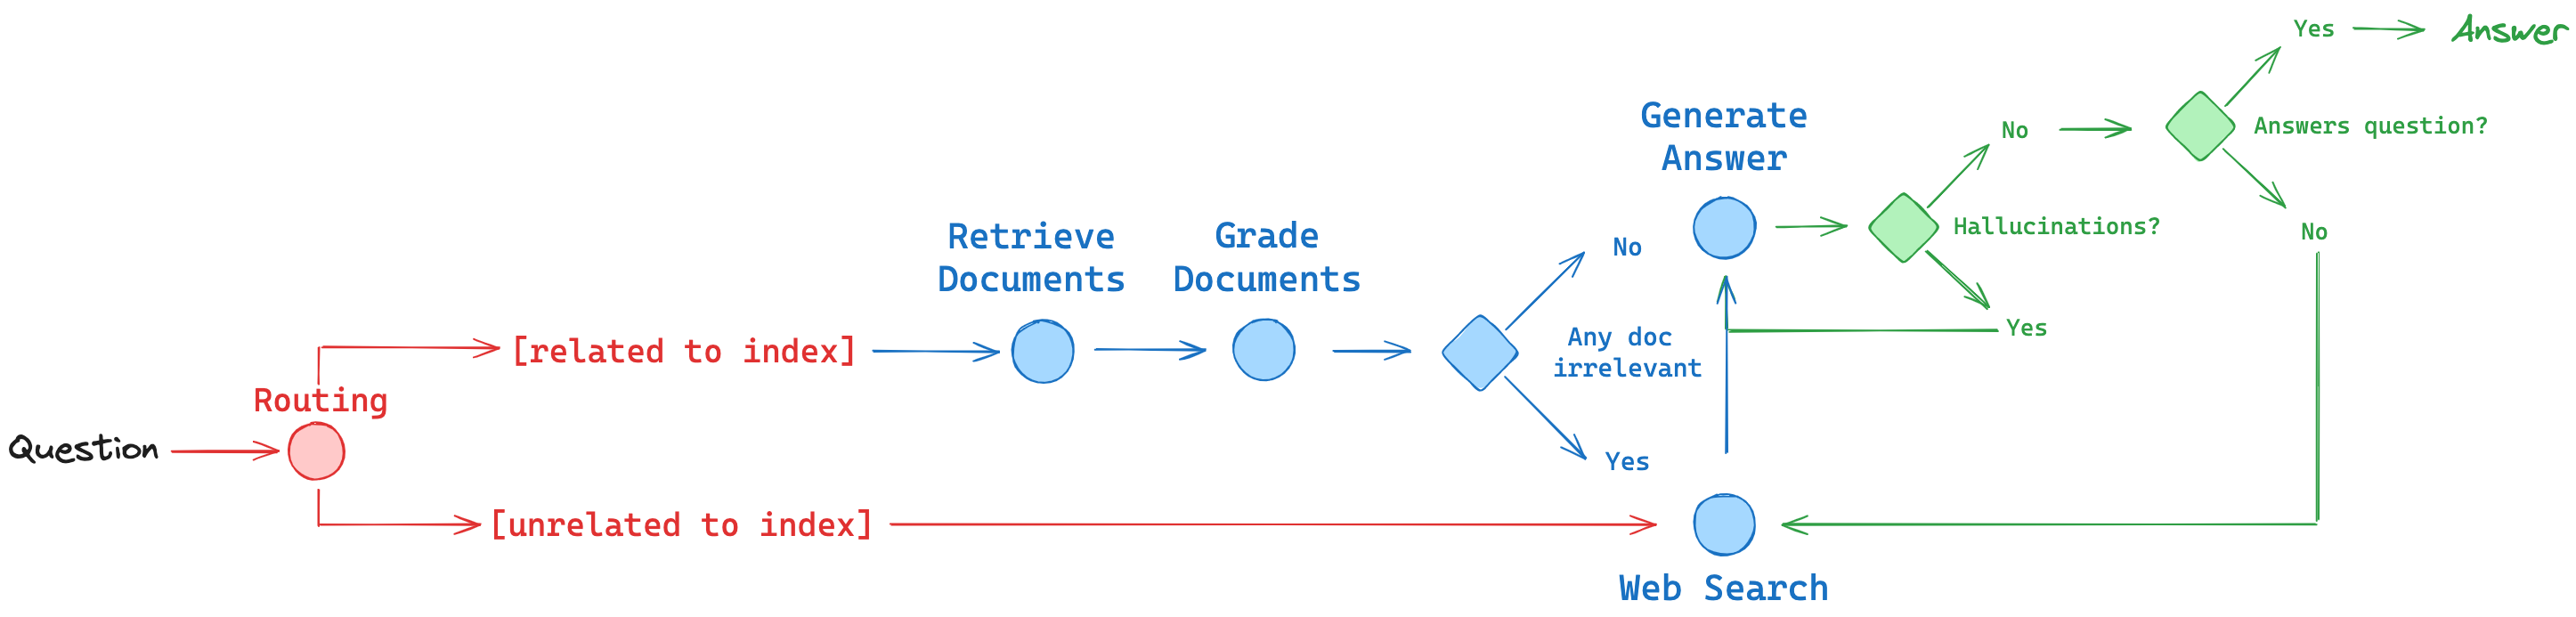

Note that this will incorperate [a few general ideas for agents](https://www.deeplearning.ai/the-batch/how-agents-can-improve-llm-performance/):

- **Reflection**: The self-correction mechanism is a form of reflection, where the LangGraph agent reflects on its retrieval and generations
- **Planning**: The control flow laid out in the graph is a form of planning 
- **Tool use**: Specific nodes in the control flow (e.g., web search) will use tools

## Local models

#### Embedding
 
[GPT4All Embeddings](https://blog.nomic.ai/posts/nomic-embed-text-v1):

```
pip install langchain-nomic
```

### LLM

Use [Ollama](https://ollama.ai/) and [llama3](https://ollama.ai/library/llama3):

```
ollama pull llama3
```

Prompt - 

https://llama.meta.com/docs/model-cards-and-prompt-formats/meta-llama-3/

### Tracing

```
### Tracing (optional)
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = 'LANGCHAIN_API_KEY'
```

### Search

Uses [Tavily](https://tavily.com/#api)

In [ ]:
import os

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = 'LANGCHAIN_API_KEY'

os.environ['TAVILY_API_KEY'] = 'TAVILY_API_KEY'

In [ ]:
### LLM

local_llm = 'llama3'

In [ ]:
### Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=HuggingFaceEmbeddings(),
)
retriever = vectorstore.as_retriever()

In [ ]:
### Retrieval Grader 

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""You are a grader assessing relevance 
    of a retrieved document to a user question. If the document contains keywords related to the user question, 
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. 
    
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
    Provide the binary score as a JSON with a single key 'score' and no premable or explaination.
     
    Here is the retrieved document: 
    {document}
    
    Here is the user question: 
    {question}
    """,
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

In [ ]:
### Generate

from langchain.prompts import PromptTemplate
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Context: {context} 
    Answer: 
    """,
    input_variables=["question", "document"],
)

llm = ChatOllama(model=local_llm, temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
question = "agent memory"
docs = retriever.invoke(question)
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

In [ ]:
### Hallucination Grader 

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether 
    an answer is grounded in / supported by a set of facts. Give a binary score 'yes' or 'no' score to indicate 
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a 
    single key 'score' and no preamble or explanation.
    
    Here are the facts:
    {documents} 

    Here is the answer: 
    {generation}
    """,
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

In [ ]:
### Answer Grader 

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an 
    answer is useful to resolve a question. Give a binary score 'yes' or 'no' to indicate whether the answer is 
    useful to resolve a question. Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
     
    Here is the answer:
    {generation} 

    Here is the question: {question}
    """,
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question,"generation": generation})

In [ ]:
### Router

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""You are an expert at routing a 
    user question to a vectorstore or web search. Use the vectorstore for questions on LLM  agents, 
    prompt engineering, and adversarial attacks. You do not need to be stringent with the keywords 
    in the question related to these topics. Otherwise, use web-search. Give a binary choice 'web_search' 
    or 'vectorstore' based on the question. Return the a JSON with a single key 'datasource' and 
    no premable or explaination. 
    
    Question to route: 
    {question}""",
    input_variables=["question"],
)

question_router = prompt | llm | JsonOutputParser()
question = "llm agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(question_router.invoke({"question": question}))

In [ ]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

We'll implement these as a control flow in LangGraph.

In [ ]:
from typing_extensions import TypedDict
from typing import List

### State

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents 
    """
    question : str
    generation : str
    web_search : str
    documents : List[str]

from langchain.schema import Document

### Nodes

def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score['score']
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}
    
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "question": question}

### Conditional edge

def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    print(question)
    source = question_router.invoke({"question": question})  
    print(source)
    print(source['datasource'])
    if source['datasource'] == 'web_search':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source['datasource'] == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

### Conditional edge

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score['score']

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question,"generation": generation})
        grade = score['score']
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

from langgraph.graph import END, StateGraph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generatae

### Graph Build

In [ ]:
# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
    },
)

In [ ]:
# Compile
app = workflow.compile()

# Test
from pprint import pprint
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

Trace: 

https://smith.langchain.com/public/8d449b67-6bc4-4ecf-9153-759cd21df24f/r

In [ ]:
# Compile
app = workflow.compile()

# Test
from pprint import pprint
inputs = {"question": "Who are the Bears expected to draft first in the NFL draft?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

Trace: 

https://smith.langchain.com/public/c785f9c0-f519-4a38-ad5a-febb59a2139c/r